In [49]:
# Import the keys
import os
from dotenv import load_dotenv
load_dotenv()

WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']


# Retrieve credentials from environment variables
openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")


In [50]:
# Import the required libraries and methods
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

In [51]:
# If you have OpenAI key
# llm = ChatOpenAI(model="gpt-4o-mini", api_key="sk-U7tijaa4jwHvhVWGr....", temperature=0)


## if you have azure openai

from langchain_openai import AzureChatOpenAI

model=  "gpt-4o-mini"


if not os.environ.get("AZURE_OPENAI_API_KEY"):
  os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=model,
    openai_api_version=openai_api_version,
)


In [52]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

### APIs to Simulate
You are required to simulate at least 3 out of the 5 following APIs using functions. The agent
should dynamically determine the right function(s) to call based on the user&#39;s query and
retain context for follow-up questions.

#### Financial Data Function

Function Name: `get_financial_data(query)`
Example Queries:
- What is the stock price of Tesla?
- How is Bitcoin performing today?

#### Weather Function
Function Name: `get_weather(query)`
Example Queries:
- What&#39;s the weather like in Tokyo?
- Will it rain in New York tomorrow?


#### News Function
Function Name: `get_news(query)`
Example Queries:
- Tell me the latest news about AI.
- Any updates on the electric vehicle industry?


#### Sentiment Analysis Function
Function Name: `analyze_sentiment(query)`
Example Queries:

- Analyze the sentiment of &#39;The product is amazing, but delivery was slow.&#39;
- What do people think about OpenAI?


#### Translation Function
Function Name: `translate_text(query)`
Example Queries:
- Translate &#39;How are you?&#39; into French.
- How do you say &#39;Good morning&#39; in Spanish?

In [53]:
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

@tool
def search_web(query: str) -> list:
    """Search the web for a query"""
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=2, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke(query)
    return results


@tool
def translate(query: str)-> str:
    
    

In [54]:
tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

In [55]:
tools = [search_web, get_weather]
tool_node = ToolNode(tools)

tool_node

tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={'writer': False, 'store': True}, tools_by_name={'search_web': StructuredTool(name='search_web', description='Search the web for a query', args_schema=<class 'langchain_core.utils.pydantic.search_web'>, func=<function search_web at 0x00000220F90AF100>), 'get_weather': StructuredTool(name='get_weather', description='Search weatherapi to get the current weather', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x00000220F9024CC0>)}, tool_to_state_args={'search_web': {}, 'get_weather': {}}, tool_to_store_arg={'search_web': None, 'get_weather': None}, handle_tool_errors=True, messages_key='messages')

In [56]:
def call_model(state: MessagesState):
    messages = state["messages"]
    print("----------------------------------call_model----------------------------------------")
    print(messages)
    print("----------------------------------call_model----------------------------------------")
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    print("----------------------------------call_tools----------------------------------------")
    print(messages)
    last_message = messages[-1]
    print(last_message)
    check_tool=last_message.tool_calls
    print("called tool info:", check_tool)
    print("----------------------------------call_tools----------------------------------------")
    
    if check_tool:
        return "tools"
    return END

In [57]:
# initialize the workflow from StateGraph
workflow = StateGraph(MessagesState)

# add a node named LLM, with call_model function. This node uses an LLM to make decisions based on the input given
workflow.add_node("LLM", call_model)

# Our workflow starts with the LLM node
workflow.add_edge(START, "LLM")

# Add a tools node
workflow.add_node("tools", tool_node)

# Add a conditional edge from LLM to call_tools function. It can go tools node or end depending on the output of the LLM. 
workflow.add_conditional_edges("LLM", call_tools)

# tools node sends the information back to the LLM
workflow.add_edge("tools", "LLM")

agent = workflow.compile()

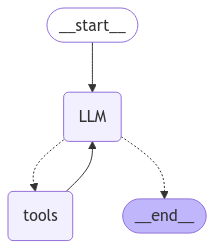

In [58]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [65]:
for chunk in agent.stream(
    {"messages": [("user", "What do people think about OpenAI?- analyze its sentiment")]},
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What do people think about OpenAI?- analyze its sentiment
----------------------------------call_model----------------------------------------
[HumanMessage(content='What do people think about OpenAI?- analyze its sentiment', additional_kwargs={}, response_metadata={}, id='cc7c8042-9760-4baa-bf81-14d92d2aa266')]
----------------------------------call_model----------------------------------------
----------------------------------call_tools----------------------------------------
[HumanMessage(content='What do people think about OpenAI?- analyze its sentiment', additional_kwargs={}, response_metadata={}, id='cc7c8042-9760-4baa-bf81-14d92d2aa266'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LQXuqf6W8g45PB5GILhSzJom', 'function': {'arguments': '{"query":"OpenAI sentiment analysis"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'c

In [ ]:
Work-from-Home (WFH) Assignment: Intelligent API Router
Objective
The goal of this assignment is to develop an AI-powered agent framework that processes
free-text queries, intelligently routes them to the appropriate function(s) based on intent,
and utilizes memory to maintain context across interactions. The focus is on intent
detection, routing logic, memory usage, and modular agent design rather than backend API
development.
APIs to Simulate
You are required to simulate at least 3 out of the 5 following APIs using functions. The agent
should dynamically determine the right function(s) to call based on the user&#39;s query and
retain context for follow-up questions.
Financial Data Function
Function Name: `get_financial_data(query)`
Example Queries:
- What is the stock price of Tesla?
- How is Bitcoin performing today?
Weather Function
Function Name: `get_weather(query)`
Example Queries:
- What&#39;s the weather like in Tokyo?
- Will it rain in New York tomorrow?
News Function
Function Name: `get_news(query)`
Example Queries:
- Tell me the latest news about AI.
- Any updates on the electric vehicle industry?
Sentiment Analysis Function
Function Name: `analyze_sentiment(query)`
Example Queries:

- Analyze the sentiment of &#39;The product is amazing, but delivery was slow.&#39;
- What do people think about OpenAI?
Translation Function
Function Name: `translate_text(query)`
Example Queries:
- Translate &#39;How are you?&#39; into French.
- How do you say &#39;Good morning&#39; in Spanish?
Task: Build an AI Agent-Based Router
Develop an AI-driven agent framework that takes free-text input, identifies intent, extracts
entities, routes the query to the appropriate function(s), and retains memory to support
multi-turn conversations.
1️⃣ Input:
Users send a free-text query to the agent framework.
Example request:
{
&quot;query&quot;: &quot;What is the stock price of Tesla?&quot;
}
2️⃣ Processing:
You must use an agent framework (e.g., LangChain, OpenAI Agents, CrewAI, etc.) to
structure the routing logic.
Your agent should:
- Identify Intent: Determine if the query is about finance, weather, news, sentiment
analysis, or translation.
- Extract Key Entities: Identify relevant companies, locations, and keywords.
- Route to Correct Function(s): Determine which function(s) should be called.
- Handle Edge Cases: If the intent is unclear, the agent should respond accordingly.
- Utilize Memory: Implement memory retention where the agent can remember past
interactions and refine responses accordingly.
3️⃣ Memory Usage &amp; Expected Behavior:
Your agent should remember past interactions and adjust its responses accordingly.
Example:

User Query Agent Memory (Stored) Action Taken
What is the stock price of
Tesla?

Intent: Finance (Stock) Calls Financial Data

Function

What about Apple? Recognizes previous stock

query

Calls Financial Data
Function for Apple
Tell me the latest news. Intent: News Calls News Function
And Bitcoin’s
performance?

Recognizes Finance topic Calls Financial Data
Function for Bitcoin

Translate &#39;Hello&#39; into
French.

Intent: Translation Calls Translation Function
The agent should be able to recall previous interactions and handle follow-up queries
accordingly.
4️⃣ Memory Implementation Options:
You may use an existing memory solution or implement a simple dictionary-based memory.
Suggested approaches:
- LangChain Memory: Use `ConversationBufferMemory` or
`ConversationSummaryMemory` to track user queries.
- Custom Python Dictionary-Based Memory: Store previous intents in a dictionary and
retrieve them when needed.
Example for LangChain Memory:

from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory()
memory.save_context({&quot;input&quot;: &quot;What is the stock price of Tesla?&quot;}, {&quot;output&quot;: &quot;Tesla&#39;s stock
price is $824.32.&quot;})
print(memory.load_memory_variables({}))

Deliverables
You are required to submit the following:
1. Agent Design Document (1-2 pages)
- Explain the architecture of the agent framework.
- How does the agent process and classify queries?
- How does the agent map queries to functions?
- How does the agent handle memory usage, edge cases, and multi-step queries?
2. Python Implementation
- Implement an agent-driven function router.
- Implement at least 3 function endpoints (`get_financial_data`, `get_weather`, etc.).
- Use a popular agent framework (LangChain, OpenAI Agents, CrewAI, etc.).

3. Example Queries &amp; Responses
- Provide 5 example queries with expected function outputs.
Evaluation Criteria
✅ Routing Logic &amp; Intent Detection – How well queries are classified and routed.
✅ Agent Framework Implementation – How effectively an agent framework is used.
✅ Memory Usage – How well memory is utilized for multi-turn interactions.
✅ Code Quality – Readable, maintainable, and well-structured.
✅ Handling Edge Cases – Graceful failure handling and proper response messages.
✅ Bonus – If the agent can handle multi-step queries such as &#39;Stock price of Apple and
sentiment around it.&#39; by calling multiple functions sequentially.
Bonus Challenge (Optional)
For advanced candidates, allow memory to persist across multiple interactions, so a user
does not lose context even if they exit and return later.




your task is to implemet the soution using langraph you can  take the reference for below code:

import os
from dotenv import load_dotenv
load_dotenv()

WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']


# Retrieve credentials from environment variables
openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")

# Import the required libraries and methods
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

# If you have OpenAI key
# llm = ChatOpenAI(model="gpt-4o-mini", api_key="sk-U7tijaa4jwHvhVWGr....", temperature=0)


## if you have azure openai

from langchain_openai import AzureChatOpenAI

model=  "gpt-4o-mini"


if not os.environ.get("AZURE_OPENAI_API_KEY"):
  os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=model,
    openai_api_version=openai_api_version,
)

from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

@tool
def search_web(query: str) -> list:
    """Search the web for a query"""
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=2, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke(query)
    return results

tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

tools = [search_web, get_weather]
tool_node = ToolNode(tools)

def call_model(state: MessagesState):
    messages = state["messages"]
    print("----------------------------------call_model----------------------------------------")
    print(messages)
    print("----------------------------------call_model----------------------------------------")
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    print("----------------------------------call_tools----------------------------------------")
    print(messages)
    last_message = messages[-1]
    print(last_message)
    check_tool=last_message.tool_calls
    print("called tool info:", check_tool)
    print("----------------------------------call_tools----------------------------------------")
    
    if check_tool:
        return "tools"
    return END

# initialize the workflow from StateGraph
workflow = StateGraph(MessagesState)

# add a node named LLM, with call_model function. This node uses an LLM to make decisions based on the input given
workflow.add_node("LLM", call_model)

# Our workflow starts with the LLM node
workflow.add_edge(START, "LLM")

# Add a tools node
workflow.add_node("tools", tool_node)

# Add a conditional edge from LLM to call_tools function. It can go tools node or end depending on the output of the LLM. 
workflow.add_conditional_edges("LLM", call_tools)

# tools node sends the information back to the LLM
workflow.add_edge("tools", "LLM")

agent = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

for chunk in agent.stream(
    {"messages": [("user", "What is the stock price of Tesla?")]},
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()